(t = 2800 )
Training Layer:  3
Hidden Act: [ 0.0 , 0.2809544 , 3.200163 ]
NextIn Act: [ -0.8725177 , -0.00024293878 , 2.6512332 ]
Accuracy Per Layer: [0.8858000040054321, 0.8679999709129333, 0.8518999814987183]


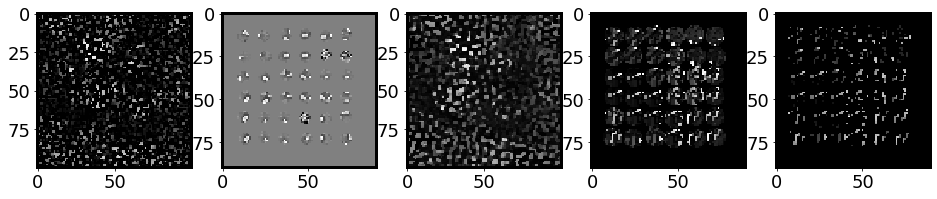

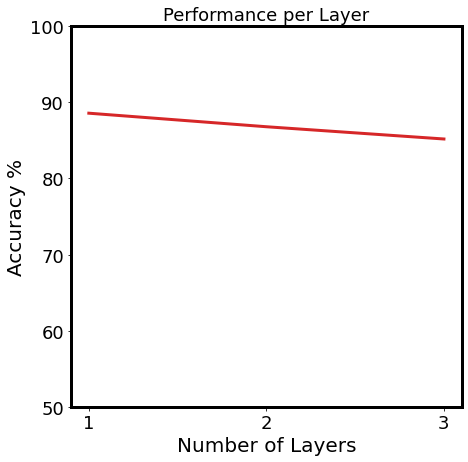

Epoch 1/10
3000/3000 [==============================] - 54s 17ms/step - loss: 0.7339 - accuracy: 0.7511
Epoch 2/10
3000/3000 [==============================] - 54s 18ms/step - loss: 0.6146 - accuracy: 0.7892
Epoch 3/10
3000/3000 [==============================] - 55s 18ms/step - loss: 0.5841 - accuracy: 0.7995
Epoch 4/10
3000/3000 [==============================] - 54s 18ms/step - loss: 0.5584 - accuracy: 0.8089
Epoch 5/10
3000/3000 [==============================] - 54s 18ms/step - loss: 0.5487 - accuracy: 0.8098
Epoch 6/10
3000/3000 [==============================] - 54s 18ms/step - loss: 0.5335 - accuracy: 0.8162
Epoch 7/10
3000/3000 [==============================] - 55s 18ms/step - loss: 0.5247 - accuracy: 0.8164
Epoch 8/10
3000/3000 [==============================] - 54s 18ms/step - loss: 0.5183 - accuracy: 0.8181
Epoch 9/10
3000/3000 [==============================] - 54s 18ms/step - loss: 0.5159 - accuracy: 0.8200
Epoch 10/10
3000/3000 [==============================] - 53s 18m

In [ ]:
%tensorflow_version 2.x
%matplotlib inline

!pip install import_ipynb # Should allow other jupiter notebooks to be loaded using import
!pip install tfa-nightly # Needed to get tensorflow image addons working (2.7.1 works)


# -*- coding: utf-8 -*-
"""
Created on Mon Nov/19/2020

@author: James Ryland

For non-gradient learning
-   Simple layer uses basic kohonen/lissom like learning
        +Relu layer that targets itself but with lateral inhibition and exictation
-   The point of this is simply to make a one layer version of the network 
    that has no complex cell layer at all and simple puts the temporal dynamics
    all in the first layer

   out
    |
  Relu
    |
ArborLayer
    |
  Relu
    |
ArborLayer
    |
    In

Notes:  Unexpected behavior - network with no training performs very well
        already, this is probably due to the large number of diverse filters
        that are unique to each location. Need to see if this holds up with
        more than one layer.

"""
import import_ipynb
import ArborLayer

import gc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from   tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow.keras as keras
import numpy as np
from scipy.stats import chi2
from IPython.display import clear_output


print(tf.__version__)

# Style for plotting
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

# Setup some basic font size thingies
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes' , linewidth =3)
plt.rc('lines', linewidth =3)
plt.rc('lines', markersize =10)

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


# A standard type of image normalization that typically helps with CIFAR10 like
# datasets
def ItemBoxNorm(in_im): # BWHC
    iMax = tf.reduce_max(tf.abs(in_im), axis=[1,2,3], keepdims=True)
    iMin = tf.reduce_min(tf.abs(in_im), axis=[1,2,3], keepdims=True)
    in_im = in_im/((iMax)+.0000000001)
    return in_im

class ReflectTile3x3(layers.Layer):
    def __init__(self):
        super().__init__()
    def call(self, x): # Batch dimension is assumed to be 0
        x_nn = x
        x_rn = tf.reverse(x, axis=[1])
        y_n = tf.concat([x_rn, x, x_rn], axis=1)
        y_r = tf.reverse(y_n, axis=[2])
        tile3x3 = tf.concat([y_r, y_n, y_r], axis=2)
        return tile3x3


class ItemPicker():
    def __init__(self, batch, item_labels, itemSwitch, catSwitch):
        
        self.batch = batch
        self.item_labels = item_labels
        self.itemSwitch = itemSwitch
        self.catSwitch = catSwitch

        self.numCats = item_labels.shape[1]

        # Find the indices of each category of images
        self.indsByCat = []
        for i in range(0, self.numCats):
            self.indsByCat.append( np.where(item_labels[:,i])[0] )

        self.t = 0

        # initialized the batch categories shown
        self.bCats = np.random.choice(self.numCats, size=[self.batch])
        self.bPicks = np.zeros((self.batch), dtype=np.int32)

    def Settings(self, itemSwitch, catSwitch):
        self.itemSwitch=itemSwitch
        self.catSwitch=catSwitch

    def GetPicks(self):

        if np.mod(self.t, self.catSwitch)==0 or 0:
            # Swith the batch categories
            self.bCats = np.random.choice(self.numCats, size=[self.batch])
        
        if np.mod(self.t, self.itemSwitch)==0 or 0:
            # Find the index for each new item in the batch
            for i in range(0, self.batch):
                self.bPicks[i] = np.random.choice(self.indsByCat[ self.bCats[i] ])

        self.t=self.t+1
        return self.bPicks

    def __call__(self):
        return self.GetPicks()


class TemporalAugmentLayer(layers.Layer):
    def __init__(self, batch, episodeSteps, phiSpeed = .1, shiftSpeed = .1, speedMultiplier = 1, momentum=0, changeEachStep=False):
        super().__init__()
        self.batch     = batch
        self.epSteps   = episodeSteps
        self.shiftSpeed = shiftSpeed
        self.phiSpeed = phiSpeed
        self.beta = (1.0-momentum)
        self.offMoment = 0 
        self.phiMoment = 0
        self.speedMult = speedMultiplier
        self.t = 0

        self.changeEachStep = changeEachStep

        self.Reflect3x3 = ReflectTile3x3() 
        
    def build(self, inShape):
        self.inShape = inShape
        self.angle  = np.random.uniform(-np.pi, np.pi, size=[self.batch])
        self.initOff()
        self.offset = np.zeros([self.batch, 2])
        self.crop   = layers.experimental.preprocessing.CenterCrop(inShape[1],inShape[2])
        self.images = None

        self.randDir = np.random.uniform(-1,1, size=(self.batch, 2) )

        # reset! at the beginning to have a random initialization
        self.reset()

    def adjustSpeed(self,speedMult):
        self.speedMult = speedMult

    def reset(self):
        self.angle  = np.random.uniform(-np.pi, np.pi, size=[self.batch])
        if self.phiSpeed==0:
            self.angle = np.zeros([self.batch])
        self.initOff()
        #pass 

    def initOff(self):
        self.offset = np.random.uniform(-1/3, 1/3, size=[self.batch, 2])
        rho, phi = cart2pol(self.offset[:,0], self.offset[:,1])
        xRot, yRot = pol2cart(rho, phi+self.angle)
        self.offset = np.concatenate( (xRot[:,np.newaxis], yRot[:,np.newaxis]), axis=1)

    def packManLoop(self):
        rho, phi = cart2pol(self.offset[:,0], self.offset[:,1])
        xRot, yRot = pol2cart(rho, phi-self.angle)
        xRot = np.mod(xRot+1/3,2/3)-1/3
        yRot = np.mod(yRot+1/3,2/3)-1/3
        rho, phi = cart2pol(xRot, yRot)
        xRot, yRot = pol2cart(rho, phi+self.angle)
        self.offset = np.concatenate( (xRot[:,np.newaxis], yRot[:,np.newaxis]), axis=1)

    def updateViews(self):
        
        # Switch these to np.random.normals
        self.phiDelta = np.random.normal(0, self.phiSpeed, self.angle.shape)*self.speedMult
        self.offDelta = np.random.normal(0, self.shiftSpeed, self.offset.shape)*self.speedMult
        self.phiMoment = self.phiMoment*(1-self.beta)+self.phiDelta*(self.beta)
        self.offMoment = self.offMoment*(1-self.beta)+self.offDelta*(self.beta) 

        # Update viewing p
        self.angle  = self.angle + self.phiMoment
        self.offset = self.offset + self.offMoment
        
        # Baundaries
        self.packManLoop()
    
    def call(self, x):
        #update object views
        if self.t<self.epSteps and not self.images==None:
            if self.changeEachStep:
                self.images = tf.convert_to_tensor(x)
            x = self.images
            self.updateViews()
            self.t=self.t+1
        # update object identities
        else: 
            self.reset()
            self.images = tf.convert_to_tensor(x)
            self.t=0
        # Transform objects smoothly    
        #x = tf.tile(x, [1,3,3,1])
        x = self.Reflect3x3(x)
        x = tfa.image.rotate(x, self.angle)
        x = tf.image.extract_glimpse(x, self.inShape[1:3], self.offset)
        x = self.crop(x)
        return x

class BufferLayer(layers.Layer): # Will buffer accross batch!! this is good behavior
    def __init__(self, buffLength):
        super().__init__()
        self.buffLength = buffLength

    def build(self, inShape): # Assumes constant batch size for training...
        self.inShape = inShape
        self.ToVec   = layers.Reshape([np.prod(inShape[1:]), 1])
        self.ToOut   = layers.Reshape(inShape[1:]) # Assuming batch size is constant
        self.buff = self.add_weight(shape=[inShape[0], np.prod(inShape[1:]), self.buffLength], 
                                    initializer='zeros',
                                    trainable=False)

    def toShape(self, vec):
        return self.ToOut(vec)

    def call(self, x, training=True):
        if training:
            x = self.ToVec(x)
            buffPlus = tf.concat([x,self.buff], axis=2)
            self.buff.assign(buffPlus[:,:,0:self.buffLength])
        return self.buff


class OneBackLayer(layers.Layer): # Will buffer accross batch!! this is good behavior
    def __init__(self):
        super().__init__()
        #self.back1 = self.add_weight(   inShape, 
        #                                initializer='zeros',
        #                                trainable=False)


    def build(self, inShape): # Assumes constant batch size for training...
        print(inShape)
        self.back1 = self.add_weight(   shape=inShape, 
                                        initializer='zeros',
                                        trainable=False)

    def call(self, x, training=True):
        oldVal = self.back1+0 # A trick to create a tensor that won't change
        if training:
            self.back1.assign(x) # Update the buffer
        return oldVal

class BasicTraceLayer(layers.Layer): # Will buffer accross batch!! this is good behavior
    def __init__(self, beta=.1):
        super().__init__()
        self.beta = beta
        

    def build(self, inShape):
        print(inShape)
        self.trace = self.add_weight(   shape=inShape, 
                                        initializer='zeros',
                                        trainable=False)

    def call(self, x, training=True):
        oldVal = self.trace+0 # A trick to create a tensor that won't change
        if training:
            self.trace.assign(self.trace*(1-self.beta) + x*(self.beta)) # Update the buffer
        return oldVal

def test_TemporalAugmentLayer():
    #fashion_mnist = keras.datasets.fashion_mnist
    #fashion_mnist = keras.datasets.mnist
    fashion_mnist = keras.datasets.cifar10
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    #train_images = train_images[:,:,:,np.newaxis]
    #test_images = test_images[:,:,:,np.newaxis]
    train_images = train_images[:,:,:,:]
    test_images = test_images[:,:,:,:]


    # Normalize images
    train_images = (train_images/255.0).astype(np.float32)
    test_images = (test_images/255.0).astype(np.float32)

    # Setup temporal augmentation layer
    batch = 10
    TempAug = TemporalAugmentLayer(batch,50, shiftSpeed=.4, phiSpeed=.4, speedMultiplier = 1, momentum=.99, changeEachStep=True)
    print(train_images.shape[1:])
    imShape = train_images.shape
    ToIm = layers.Reshape( train_images.shape[1:] )
    Buff = BufferLayer(20)

    hotIm = 0   

    oneHotLabels = keras.utils.to_categorical(train_labels, 10)
    Picker = ItemPicker(batch, oneHotLabels, 3, 10)
    
    for i in range(0, 200):
        #picks = np.random.choice(train_images.shape[0], size=[batch])
        picks = Picker()
        in_imRaw = train_images[picks,:,:,:]
        in_im = TempAug(in_imRaw)
        b_vecs = Buff(in_im, training=True)
        b_vec = b_vecs[:,:, 5]
        b_im = ToIm(b_vec)
        in_im_k = ToIm(b_im)

        #clear_output()
        fig = plt.figure()
        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(in_im[0,:,:,:], cmap='gray', interpolation='nearest')

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(in_im_k[0,:,:,:], cmap='gray', interpolation='nearest')

        plt.show()
        plt.pause(.1)

#test_TemporalAugmentLayer()


class GaussianFilterLayer(layers.Layer):
    def __init__(self, gauWidth, filtRad, norm=False, pad="NONE"):
        super().__init__()
        self.gauWidth  = gauWidth
        self.filtRad = filtRad
        self.norm = norm
        self.pad = pad

    def build(self, inShape):
        self.x = np.linspace(-self.filtRad,self.filtRad, self.filtRad*2+1)
        self.imSz = inShape[1:3]
        self.imC  = inShape[3] 

    def call(self, in_im):
        self.gau = tf.cast(tf.exp(-tf.math.pow(self.x/self.gauWidth,2)*.5), tf.float32)
        if self.norm:
            self.gau = self.gau/tf.reduce_sum(self.gau)
        padding = 'SAME'
        if not self.pad == "NONE":
            padding='VALID'
            ff = [self.filtRad,self.filtRad]
            in_im = tf.pad(in_im, np.array([[0,0],ff,ff,[0,0]]), self.pad)
        horGau = tf.repeat(self.gau[:, tf.newaxis, tf.newaxis, tf.newaxis], self.imC, axis=2)
        in_im = tf.nn.depthwise_conv2d(in_im, horGau, strides=[1,1,1,1], padding=padding)
        verGau = tf.repeat(self.gau[tf.newaxis, :, tf.newaxis, tf.newaxis], self.imC, axis=2)
        in_im = tf.nn.depthwise_conv2d(in_im, verGau, strides=[1,1,1,1], padding=padding)
        return in_im




class LateralEILayer(layers.Layer):
    def __init__(self, Ewidth, Iwidth, filtRad, norm=True, pad='NONE', bias = [1, 1]):
        super().__init__()
        self.Exc = GaussianFilterLayer(Ewidth, filtRad,norm=norm, pad=pad)
        self.Inh = GaussianFilterLayer(Iwidth, filtRad,norm=norm, pad=pad)
        self.Ewidth = Ewidth
        self.Iwidth = Iwidth
        self.norm=norm
        self.bias=bias

    def build(self, inShape):
        pass

    def call(self, in_im):
        E = self.Exc(in_im) * self.bias[0]
        I = self.Inh(in_im) * self.bias[1]
        if not self.norm:
            I = I/tf.pow(self.Iwidth/self.Ewidth, 2)
        out_im = E-I
        return out_im

class CenterSurround(layers.Layer):
    def __init__(self, sig, filtRad):
        super().__init__()
        # Layers
        self.Gau = GaussianFilterLayer(sig, filtRad, norm=True, pad='REFLECT')
    def call(self, x):
        x = x - self.Gau(x)
        return x

class CenterSurroundEI(layers.Layer):
    def __init__(self, sig, filtRad):
        super().__init__()
        # Layers
        self.GauE = GaussianFilterLayer(sig[0], filtRad[0], norm=True, pad='REFLECT')
        self.GauI = GaussianFilterLayer(sig[1], filtRad[1], norm=True, pad='REFLECT')
    def call(self, x):
        x = self.GauE(x) - self.GauI(x)
        return x

#_______________________________________________________________________________
# A bit like a gain controll layer
class WindNormLayer( layers.Layer ):

    def __init__(self, widthGau, widthCC = 1, alpha = 0.01, mult=1.0):    
        super().__init__()
        self.alpha = alpha
        self.mult = mult
        # Difference with local mean
        self.CC = CenterSurround(widthCC, widthGau)
        # Sum over local differences
        self.Gau = GaussianFilterLayer(widthGau, 12, norm=False, pad='REFLECT') # Try with pad (not having this may be causing problems after the first layer...)
                                                                                # If this is the case it needs to be fixed everywhere...

    def call(self, in_im):
        dif = self.CC(in_im)
        var = self.Gau(tf.abs(dif))
        var = tf.nn.relu(var)   # Safety to ensure numerical approx 
                                # from gau does not leave negative numbers
        x = dif/(tf.sqrt(var)+ self.alpha)
        x = x*self.mult
        return x

# Scale all units to population average
class AverageNorm(layers.Layer):

    def __init__(self, beta=.01, rescale=False):
        super().__init__()

        self.beta = beta
        self.rescale = rescale

    def build(self, inShape): # Assumes constant batch size for training...
        print(inShape)
        self.avg = self.add_weight(   shape=inShape[1:], 
                                        initializer='ones',
                                        trainable=False)

    def call(self, x, training=True):
        xOld = x
        val = x/(tf.expand_dims(self.avg, axis=0)+.000000001) #add batch dim
        if self.rescale:
            val = val*tf.reduce_mean(self.avg) # make close to average value
        if training:
            xMean = tf.reduce_mean(x, axis=0)
            self.avg.assign( self.avg*(1-self.beta)+xMean*(self.beta)  )
        return val



#_______________________________________________________________________________

# Define the proto-type integrated cortical layer
class ProtoICLayer(layers.Layer):                           #                              6x6 in current draft
                                                            #                             10x10                     .01 in draft
    def __init__(   self, hidRez, depth, nWeight=.0, nt=15, gau=.3, lat=[.5, 2], eDepth = 6*6, pDepth = 16, pRate = .01 , pStride=1,
                    latBias=[1, 1.6], beta=.5, betaN=.5, fRate=.1,  # latBias = [1,1.6] tends to work well
                    axonLearn=False, axRate=.01, preTrainBatch=10, cMethod="trace", cWeight="full", cUpdate='competitive'): #wRate=.01, coactRate=100, chemoRate=.000001, compRate=1
        
        super().__init__()
        
        # Auto-Temporal Triplet Loss parameters
        self.nt = nt
        self.fRate = fRate
        self.epsilon = .5
        self.hidRez = hidRez
        self.axonLearn = axonLearn
        self.axRate = axRate
        self.beta = beta
        self.betaN = betaN
        self.nWeight = nWeight
        

        # Setup input arber layer
        self.depth = depth
        self.Arb = ArborLayer.ArborLayer(hidRez, self.depth) #, updateNum=updateNum, jitter=jitter, weightInit=weightInit, 
                                         #momentum=0, coactRate=coactRate, chemoRate=chemoRate, compRate=compRate)
        self.W = self.Arb.W

        # Exploration arbor for pools
        self.eDepth = eDepth
        self.Arb2 = ArborLayer.ArborLayer(hidRez, self.eDepth) #, updateNum=updateNum, jitter=jitter, weightInit=weightInit, 
                                         #momentum=0, coactRate=coactRate, chemoRate=chemoRate, compRate=compRate)

        self.V = self.Arb2.W
        if not cUpdate == 'competitive':
            self.V.assign( tf.zeros_like(self.V) )
        else:
            self.V.assign( tf.ones_like(self.V)*.1+self.V )

        # top_k inputs version for faster execution during evalutation of proto_layer
        self.pStride = pStride
        self.pRate = pRate
        self.pDepth = pDepth 
        self.Pool = ArborLayer.LocalLayer(hidRez, self.pDepth, learnInds=True)
        self.PI_rowInds = tf.tile(np.arange(0,hidRez*hidRez).astype(np.int32)[:,np.newaxis], [1, self.pDepth])

        # Complex cell learning rules basic
        self.cMethod = cMethod
        self.cWeight = cWeight 
        self.cUpdate = cUpdate

                
        # Temporal Buffer
        self.OneBack_maxWinds = OneBackLayer() #(preTrainBatch, hidRez*hidRez, self.eDepth) )
        self.OneBack_maxHid = OneBackLayer()   #(preTrainBatch, hidRez*hidRez))

        # Could make into trace layers?
        self.TraceBack_Winds = BasicTraceLayer(.3) # .3 used in current draft #(preTrainBatch, hidRez*hidRez, self.eDepth) )
        self.TraceBack_Hid = BasicTraceLayer(.3)   # .3 used in current draft #(preTrainBatch, hidRez*hidRez))
        
        # Average Norm
        self.AvgNorm = AverageNorm()


        # Lateral interactions
        self.Lat  = LateralEILayer(lat[0], lat[1]  , np.round(lat[1]*6).astype(int), pad='REFLECT', bias=latBias)
        self.LatP = LateralEILayer(lat[0], lat[1]  , np.round(lat[1]*6).astype(int), pad='REFLECT', bias=[1, 1.0])
        self.CC = CenterSurround(1,4) 

        
        # Setup reshape functions
        self.ToIm  = layers.Reshape([hidRez,hidRez,1])
        self.ToOut = layers.Reshape([hidRez,hidRez])
        self.ToVec = layers.Reshape([hidRez*hidRez])
        
        
        # Stored variables
        self.last_In  = 0
        self.last_Hid = 0
        self.last_Out = 0

        
    def build(self, inShape):
        self.inShape = inShape


    def call(self, in_im, training=False):
        if training:
            hid, out = self.train_layer(in_im)
            self.last_In  = in_im
            self.last_Hid = hid
            self.last_Out = out
            return out
        else:
            hid, in_windsBOD, out, pool_windsBOD = self.forward(in_im)
            self.last_In  = in_im
            self.last_Hid = hid
            self.last_Out = out
            return out

    def forward(self, in_im, training=False):
        
        # Simple cells
        in_windsBOD, W = self.Arb(in_im)

        # Does not normalize input windows
        x = tf.reduce_sum( in_windsBOD * W[tf.newaxis,:,:], axis=2 ) 
        x_im = self.ToIm(x) 
        hid  = tf.nn.relu(x_im)
        
        if  self.cWeight == "none":
            pool_windsBOD, Z = self.Pool(hid)
            y = tf.reduce_max( pool_windsBOD, axis=2 )
            y = tf.maximum(self.ToVec(hid),y)
        elif self.cWeight == "basic":
            pool_windsBOD, Z = self.Pool(hid)
            pool_windsBOD_weighted = pool_windsBOD*Z[tf.newaxis,:,:]
            y = tf.reduce_max( pool_windsBOD_weighted, axis=2 )
            #y = tf.maximum(self.ToVec(hid),y)
            y = self.AvgNorm(y, training=training)
        elif self.cWeight == "full":
            pool_windsBOD, Z = self.Arb2(hid)
            pool_windsBOD_weighted = pool_windsBOD*Z[tf.newaxis,:,:]
            y = tf.reduce_max( pool_windsBOD_weighted, axis=2 )
            #y = tf.maximum(self.ToVec(hid),y)
            y = self.AvgNorm(y, training=training)    
        elif self.cWeight == "square":
            pool_windsBOD, Z = self.Arb2(hid)
            sqr = (pool_windsBOD**2)*(Z[tf.newaxis,:,:]**2)
            y = tf.sqrt(tf.abs(tf.reduce_sum( sqr, axis=2 )))
            y = self.AvgNorm(y, training=training)
            
        out = self.ToIm(y)

        if self.pStride>1:
            out = out[:, ::self.pStride, ::self.pStride, :]

        return hid, in_windsBOD, out, pool_windsBOD

    def feature_learn(self, in_im, hid, in_windsBOD, out, pool_windsBOD):

        # SIMPLE CELLS
        #+++++++++++++++++++++++++++++++++
        # Soft-Normalize input windows
        in_windsNORM = in_windsBOD/(tf.norm(in_windsBOD, axis=2, keepdims=True)+self.epsilon)

        # get the lateral interactions
        h_lat = tf.nn.relu( self.Lat( hid) )
        
        # Non-temporal simple cells
        h_sharp = self.ToVec( h_lat ) 
        
        # spontanious-symmetry breaking learning signal
        W = self.Arb.W # for short
        targW = h_sharp[:,:,tf.newaxis]*(in_windsNORM-W[tf.newaxis,:,:])

        # Weight update Traditional Kohonen with renorm:
        # - may work better with positive and negative inputs
        # - Remember h_sharp generated using unnormalized windows!
        deltaW = tf.reduce_sum(targW, axis=0)
        Wnew = W+deltaW*self.fRate
        Wnew = Wnew/(tf.norm(Wnew, axis=1, keepdims=True)+.000000001)
        self.Arb.W.assign(Wnew)

        # Complex CELLS
        #+++++++++++++++++++++++++++++++++
        # no comptetive learning, just glomming
        # get full exploration windows
        axHid = hid
        axOut = out
        hid_windsBOD, V = self.Arb2(self.ToIm(hid))

        # Soft-Normalize input windows 
        #hid_windsNORM = hid_windsBOD/(tf.norm(hid_windsBOD, axis=2, keepdims=True)+self.epsilon)
        hid_windsNORM = hid_windsBOD/(tf.reduce_sum(hid_windsBOD, axis=2, keepdims=True)+.00000000001)

        Q_BOD = []
        if self.cMethod == "switch":
            # Maybe make this a kind of layer
            maxInds_t1 = tf.argmax(hid_windsBOD, axis=2)
            maxWindsBOD_t1 = tf.one_hot(maxInds_t1, depth=self.eDepth, axis=-1) #creates new right most index)
            maxWindsBOD_t1 = tf.cast(maxWindsBOD_t1, dtype= tf.float32)

            # Check if each neuron is the max within its exploration neighborhood
            maxHid_t1 = tf.cast(self.ToVec(hid)==tf.reduce_max(hid_windsBOD, axis=2), dtype=tf.float32)

            # Get older values
            maxHid_t0      = self.OneBack_maxHid(maxHid_t1)
            maxWindsBOD_t0 = self.OneBack_maxWinds(maxWindsBOD_t1)

            # Get older values using trace
            maxHid_t0      = self.TraceBack_Hid(maxHid_t1)
            maxWindsBOD_t0 = self.TraceBack_Winds(maxWindsBOD_t1)

            # Detect swiches
            hidSwitchOffOn = (maxHid_t1-maxHid_t0)
            windSwitchOffOn = (maxWindsBOD_t1-maxWindsBOD_t0)

            # Switching Learning signal
            Q_BOD = tf.nn.relu(-hidSwitchOffOn[:,:,tf.newaxis]*windSwitchOffOn[:,:,:])

            axHid = tf.nn.relu(hidSwitchOffOn)
            axOut = tf.nn.relu(-hidSwitchOffOn)

        elif self.cMethod == "delta":
            h_t1      = self.ToVec(hid)
            h_t0      = self.OneBack_maxHid(h_t1)
            windsBOD_t1 = hid_windsBOD
            windsBOD_t0 = self.OneBack_maxWinds(windsBOD_t1)
            del_h = h_t1-h_t0
            del_winds = windsBOD_t1-windsBOD_t0
            #del_winds = del_winds/(tf.reduce_mean(tf.abs(del_winds), axis=2, keepdims=True)+.0000001) # Try to correct for duplicates in border windows
            Q_BOD = -del_h[:,:,tf.newaxis] * del_winds[:,:,:]
            
            self.Pool(hid) # Force initialization even if not used

            axHid = tf.nn.relu(del_h)
            axOut = tf.nn.relu(-del_h)

        # simple trace learning signal
        elif self.cMethod == "trace":
            hidTrace  = self.TraceBack_Hid(self.ToVec(hid))
            windTrace = self.TraceBack_Winds(hid_windsBOD)
            #windTrace = self.TraceBack_Winds(hid_windsNORM)
            Q_BOD = hidTrace[:,:,tf.newaxis] * windTrace[:,:,:] # DRAFT VERSION ############## CHECK THIS TO SEE IF NORMALIZATION BY SUM HELPS FOR WINDTRACE ###### could be causing instability
            #Q_BOD = hidTrace[:,:,tf.newaxis] * hid_windsNORM 
            axHid = hidTrace
            axOut = hidTrace

        # Update exploration weights
        #Vnew = self.V + self.pRate*(Q_OD-self.V)
        
        Vnew = []
        if self.cUpdate == 'unweighted':
            Q_OD = tf.reduce_sum(Q_BOD, axis=0)
            Vnew = self.V + self.pRate*Q_OD
        elif self.cUpdate == 'competitive':
            self.Pool(hid) # Force initialization even if not used
            #z = tf.nn.relu(tf.reduce_sum(hid_windsBOD*V[tf.newaxis,:,:], axis=2))
            #z_lat = tf.nn.relu( self.LatP( self.ToIm(z) ))
            z_lat = tf.nn.relu( self.LatP( self.ToIm(out) ))
            z_lat = self.ToVec(z_lat)
            Q_BOD_norm = Q_BOD/(tf.reduce_sum(Q_BOD,axis=2,keepdims=True)+.000000001)  
            Vdelta = tf.reduce_sum(self.pRate * z_lat[:,:,tf.newaxis]*(Q_BOD), axis=0)
            Vnew = self.V + Vdelta

        # CONSIDER SOMETHING WITH A MAX?
        Vnew = Vnew/(tf.reduce_sum(tf.abs(Vnew), axis=1, keepdims=True)+.0000001)
        self.V.assign(Vnew)

        # Update pool indices/weights
        vals, poolInds = tf.math.top_k(Vnew, k=self.pDepth)
        if self.cMethod == "delta":
            vals, poolInds = tf.math.top_k(tf.abs(Vnew), k=self.pDepth)

        gatherInds = tf.stack( [self.PI_rowInds, poolInds], axis=2 )
        PInew = tf.gather_nd(self.Arb2.I, gatherInds)
        PWnew = tf.gather_nd(self.Arb2.W, gatherInds)
        self.PI = self.Pool.I
        self.PI.assign(PInew)
        self.PW = self.Pool.W
        self.PW.assign(PWnew)
        
        # Axonal learn
        if self.axonLearn:
            self.Arb.train_layer(in_im, hid, self.axRate)
            self.Arb2.train_layer(self.ToIm(axHid), self.ToIm(axOut), self.axRate) # May cause problems..
   


    # train the layer internally
    def train_layer(self, in_im):
        # Get the forward activation
        hid, in_windsBOD, out, pool_windsBOD = self.forward(in_im, training=True)
        # Feature learn
        self.feature_learn(in_im, hid, in_windsBOD, out, pool_windsBOD)

        return hid, out



class ICLNet(tf.keras.Model):

    def __init__(self, deepLearn=False, name=None, preTrainBatch=10):
        super().__init__(name=name)

        # Current training state
        self.preTrain = True 
        self.cc = WindNormLayer(6, mult = 4.0)  # 4
        self.ccIC = WindNormLayer(6, mult = 4.0) # 1.0 & 2.0 worked pretty well ! other values have actually tanked so far! 8 got good perf for first layer...
        
        self.lat  = [[.6, 2], [.6, 2], [.6, 2],  [.6, 2]] 
        self.depth = [6*6, 6*6, 6*6, 6*6]  # 6x6 seems better

        self.BatchNorm0 = layers.BatchNormalization(axis=[1,2]) #layers.BatchNormalization(axis=[1,2])
        self.BatchNorm1 = layers.BatchNormalization(axis=[1,2]) #layers.BatchNormalization(axis=[1,2])
        self.BatchNorm2 = layers.BatchNormalization(axis=[1,2]) # Just used on the last layer before the classifier (Consider replaceing with the LCN specific one)
        self.BatchNorm3 = layers.BatchNormalization(axis=[1,2])
        self.BatchNorm4 = layers.BatchNormalization(axis=[1,2])
        self.BatchNormLS = [self.BatchNorm1, self.BatchNorm2, self.BatchNorm3, self.BatchNorm4]

        # fRate .3 is accross board works well
        self.ICL1 = ProtoICLayer(100, self.depth[0], lat=self.lat[0], fRate=.3, nWeight=.0, pStride=1, axonLearn=True)
        self.ICL2 = ProtoICLayer(100, self.depth[1], lat=self.lat[1], fRate=.3, nWeight=.0, pStride=1, axonLearn=True)
        self.ICL3 = ProtoICLayer(100, self.depth[2], lat=self.lat[2], fRate=.3, nWeight=.0, pStride=1, axonLearn=True)
        self.ICL4 = ProtoICLayer(100, self.depth[3], lat=self.lat[3], fRate=.3, nWeight=.0, pStride=1, axonLearn=True)
        self.ICL_LS = [self.ICL1, self.ICL2, self.ICL3, self.ICL4]

        self.Flat = layers.Flatten()
        self.Dense1 = layers.Dense(10, activation='relu')
        self.Dense2 = layers.Dense(10, activation='relu')
        self.Dense3 = layers.Dense(10, activation='relu')
        self.Dense4 = layers.Dense(10, activation='relu')
        self.Dense_LS = [self.Dense1, self.Dense2, self.Dense3, self.Dense4]
        
        self.Drop = layers.Dropout(.3)

        # Output the activity image
        self.imOut = False
        self.deepLearn = deepLearn

        # set the training layer
        self.trainLayer = 0

    def call(self, x, training=None):
        
        # Normalize and center
        # Try switching!!
        
        x = ItemBoxNorm(x)
        x = self.cc(x)

        if self.preTrain:
            #x = self.BatchNorm0(x, training=True)
            for l in range(0, self.trainLayer+1):
                x = self.ICL_LS[l]      (x, training=(l==self.trainLayer))
                x = self.ccIC(x)
                
        else:
            #x = self.BatchNorm0(x, training=training)
            for l in range(0, self.trainLayer+1):
                x = self.ICL_LS[l]      (x, training=False)
                x = self.ccIC(x)
                
            x = self.BatchNormLS[self.trainLayer] (x, training=training) # (This is really important for performance)
            x = self.Drop(x, training=training)
            x = self.Flat(x)
            if not self.deepLearn:
                x = tf.stop_gradient(x)
            x = self.Dense_LS[self.trainLayer](x)
        return x



# A quick plot for the results of the experiment
def plotLayerPerf(acc_list):

    acc_list = np.array(acc_list)*100

    fig = plt.figure(figsize=[7,7])
    ax1 = fig.add_subplot(1,1,1)
    x_pos = np.arange(len(acc_list))+1
    line1 = ax1.plot( x_pos, acc_list, color="tab:red", label="Accuracy")
        
    #ax1.legend()
    ax1.set_title('Performance per Layer')
    ax1.set_xlabel('Number of Layers')
    ax1.set_ylabel('Accuracy %')

    ax1.set_ylim([50, 100])    

    ax1.set_xticks(x_pos)
    #ax1.set_xticklabels(["Layer 1","Layer 2","Layer 3","Layer 4"], rotation=90)

    return fig

# Quick little test for a shallow ProtoICL net...
def perfPerLayer(lastDeep=False, fullClass=True):

    fashion_mnist = keras.datasets.fashion_mnist
    labelNames = [  "top", "trouser", "pullover", "dress", "coat",
	                "sandal", "shirt", "sneaker", "bag", "ankle boot"]
    
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    train_images = train_images[:,:,:,np.newaxis]
    test_images = test_images[:,:,:,np.newaxis]


    # Setup label format correctly
    train_labels = keras.utils.to_categorical(train_labels, 10)
    test_labels = keras.utils.to_categorical(test_labels, 10)

    # Normalize images
    train_images = (train_images/255.0).astype(np.float32)
    test_images = (test_images/255.0).astype(np.float32)

    # Resize for quick proto-typing (expect lower accuracy)
    #train_images = tf.image.resize_with_crop_or_pad(train_images, 16, 16).numpy()
    #test_images = tf.image.resize_with_crop_or_pad(test_images, 16, 16).numpy()

    
    # Setup Model
    model = []
    stepNum = []

    batch = 10
    model = ICLNet(deepLearn=False, preTrainBatch=batch)

    # Setup temporal augmentation (I think these are good settings!)
    episodeLength = 10

    Picker = ItemPicker(batch, train_labels, 8, 10)

    Aug = TemporalAugmentLayer(batch, episodeLength, shiftSpeed=.4, phiSpeed=.4, 
                                   speedMultiplier = .4, momentum=.99, changeEachStep=True)
    
    # Pretraining Loop
    model.preTrain = True
    
    # Number of layers
    numLayers = 4

    # Info to keep 
    test_acc_ls = []
    train_acc_ls = []

    # maybe try compiling the model to go faster
    #model.compile()

    # Switch which layer is training
    for l in range(numLayers):
        
        model.trainLayer = l

        Aug.adjustSpeed(.4 + l*.2)
        #Picker.Settings( 8-l*2, 10+l)

        for i in range(3000):
            

            # Set visualization layer
            dispICL = model.ICL_LS[model.trainLayer]

            # Pick and augment input data
            #picks = np.random.choice(train_images.shape[0], size=[batch])
            picks = Picker()

            in_imRaw = train_images[picks,:,:,:]
            in_im = Aug(in_imRaw)
            
            # Run the model on the batch
            out_im = model(in_im, training=False)
            
            
            if np.mod(i,200)==0:
                
                clear_output()
                
                print("(t =",i,")")
                print("Training Layer: ", model.trainLayer)
                hid = dispICL.last_Hid[0,:,:,:]
                nextIn = out_im
                print("Hidden Act: [", np.min(hid) ,",", np.mean(hid),",", np.max(hid) ,"]")
                print("NextIn Act: [", np.min(nextIn) ,",", np.mean(nextIn),",", np.max(nextIn) ,"]")
                print("Accuracy Per Layer:", test_acc_ls)

                fig = plt.figure(figsize=[16,4])
                ax = fig.add_subplot(1, 5, 1)
                ax.imshow(np.squeeze(dispICL.last_Hid[0,:,:,:]), cmap='gray', interpolation='nearest')
                
                ax = fig.add_subplot(1, 5, 2)
                dispIm = dispICL.Arb.projectWeights(sampleInterval=15, projectInterval=12, center=True) 
                ax.imshow(np.squeeze(dispIm), cmap='gray', interpolation='nearest')

                ax = fig.add_subplot(1, 5, 3)
                ax.imshow(np.squeeze(dispICL.last_Out[0,:,:,:]), cmap='gray', interpolation='nearest')
                
                ax = fig.add_subplot(1, 5, 4)
                dispIm = dispICL.Arb2.projectWeights(sampleInterval=15, projectInterval=12, center=True) 
                ax.imshow(np.squeeze(dispIm), cmap='gray', interpolation='nearest')

                ax = fig.add_subplot(1, 5, 5)
                dispIm = dispICL.Pool.projectWeights(sampleInterval=15, projectInterval=12, center=True) 
                ax.imshow(np.squeeze(dispIm), cmap='gray', interpolation='nearest')
                
                if l>0:
                    fig = plotLayerPerf(test_acc_ls)
                plt.pause(.1)

        # there is a memory leak in model.fit and model.evaluate
        # so we need to force python to get rid of unused variables
        gc.collect()

        # Set last layer to deep learn
        supEpochs = 10
        if not fullClass:
            supEpochs = 2
        if l == (numLayers-1) and lastDeep:
            model.deepLearn = True 
            supEpochs = 30

        # compile sets the training paramaeters
        model.preTrain = False
        opt = tf.keras.optimizers.Adam(learning_rate=.0001)  # this is just an experiment...
        model.compile(  opt,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                run_eagerly=False,
                metrics=['accuracy'])

        #                                            15
        model.fit(train_images, train_labels, epochs=supEpochs, batch_size=20)
        test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
        print('\nTest accuracy:', test_acc)
        test_acc_ls.append(test_acc)

        print("\nAccuracy Per Layer:", test_acc_ls)
        
        test_pred = model.predict(test_images)

        # Write detailed info to the file
        classReportL = classification_report(np.argmax(test_pred,axis=-1), np.argmax(test_labels,axis=-1), target_names=labelNames)
        conf = tf.math.confusion_matrix(np.argmax(test_labels,1), np.argmax(test_pred,1))
        confReportL = np.round(conf/np.sum(conf, axis=1)*100, 0)
        
        
        # Set the model to train again!
        model.preTrain = True

    fig = plotLayerPerf(test_acc_ls)
    
#perfPerLayer(lastDeep=False, fullClass=True) 

# Note something is really slowing this down past the 1st layer...
# Figure out what it is... It may just be using the large pool exploration layers?
# instead of the compact ones... Damn roughly doubling in time for each layer :((
# Let it run for a while anyway

"""
DEMONSTRATION INSTRUCTIONS:
In the google colab enviornment make sure you have added the following files
to the environment:
- ArborLayer.ipynb 
- SimpleICLayer.ipynb 

An easy way to include a file is to download the entire repository to you computer
locally, then when nescessary drag and drop the file on your computer into the
Files tab in google colab.

Also make sure that you have selected a GPU environment as this is an intensive 
simulation that will run much faster with GPU support enable. (note that
to a GPU environment does not carry over included files so you will need to
reload them)

When this is done uncomment one of the run commands bellow and recompile. If you
want to run demonstrations from other files you may want to recomment the run
commands so that they do not run when files dependent on this one are called.
"""

# To train a 4-layer Full ICL model on Fashion-MNIST uncomment the following
# line and recompile.  
#perfPerLayer(lastDeep=False, fullClass=True) 
